参考：[compe3III(編集用)](https://colab.research.google.com/drive/1YGGpBeod_P_1XDFxqZY92R_G3iGoP6lV#scrollTo=ijN4lR_uDO_j)

共有リンク：[compe3III](https://colab.research.google.com/drive/1YGGpBeod_P_1XDFxqZY92R_G3iGoP6lV)

#1.Gdriveへマウント

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#2．ライブラリのインポート


In [0]:
#Loading dataset
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import itertools

#EDA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#model
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
#sns.set_style('whitegrid')
#pd.set_option('display.max_columns', None)

#3.データの確認

In [0]:
path = "/content/gdrive/My Drive/Colab Notebooks/GCI2019/competition3/"

def load_df(path):
    train = pd.read_csv(path + "input/train.csv")
    test = pd.read_csv(path + "input/test.csv")

    return train, test

train, test = load_df(path)

In [4]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(train.shape[0], train.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(test.shape[0], test.shape[1]))

訓練データのデータ数は7134、変数は29種類です。
テストデータのデータ数は1794、変数は28種類です


##3-1. 数値データとカテゴリカルデータ
カテゴリカルデータが4項目、数値データが25項目あることが分かる。数値データは離散値が19項目、連続値が6項目あることが分かる。

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7134 entries, 0 to 7133
Data columns (total 29 columns):
Id                 7134 non-null object
groupId            7134 non-null object
matchId            7134 non-null object
assists            7134 non-null int64
boosts             7134 non-null int64
damageDealt        7134 non-null float64
DBNOs              7134 non-null int64
headshotKills      7134 non-null int64
heals              7134 non-null int64
killPlace          7134 non-null int64
killPoints         7134 non-null int64
kills              7134 non-null int64
killStreaks        7134 non-null int64
longestKill        7134 non-null float64
matchDuration      7134 non-null int64
matchType          7134 non-null object
maxPlace           7134 non-null int64
numGroups          7134 non-null int64
rankPoints         7134 non-null int64
revives            7134 non-null int64
rideDistance       7134 non-null float64
roadKills          7134 non-null int64
swimDistance       7134 n

In [0]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

##3-2. ヒートマップ

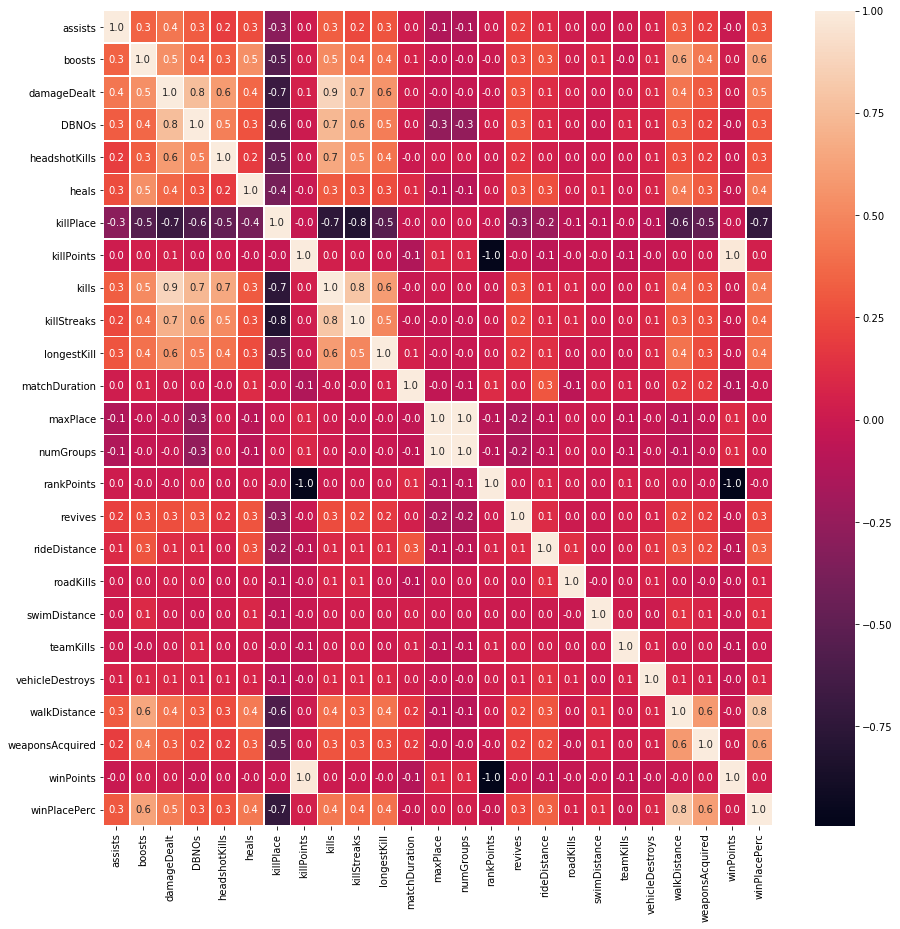

In [0]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

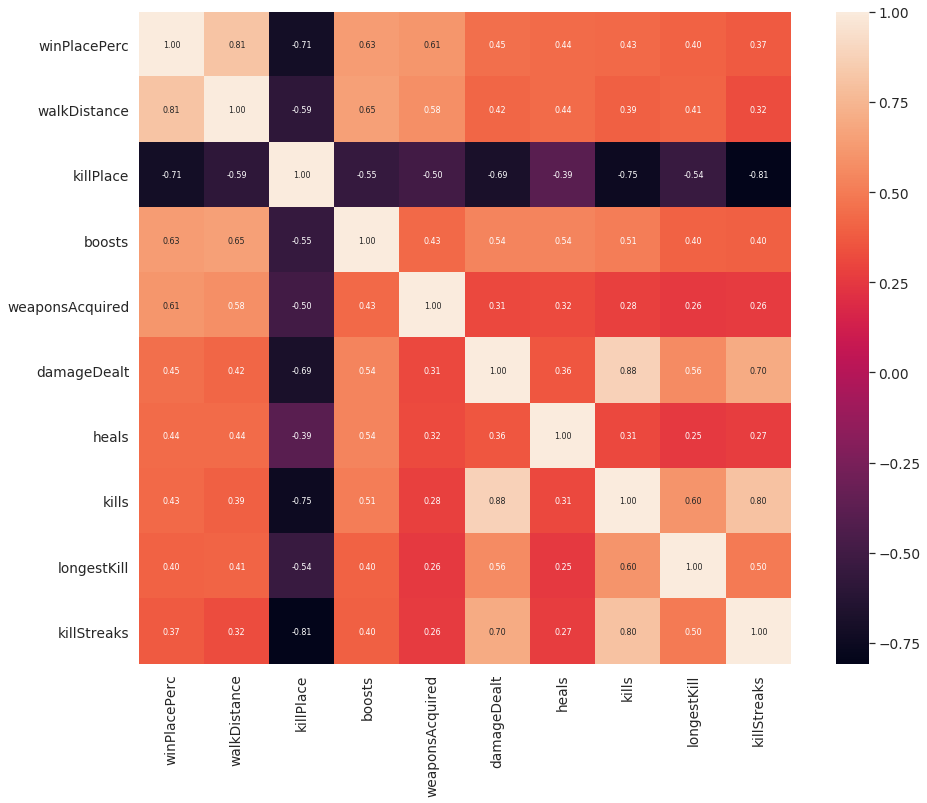

In [0]:
# ヒートマップを表示してみる
k = 10 # 表示する特徴量の数
corrmat = train.corr()
cols = corrmat.abs().nlargest(k, 'winPlacePerc').index # リストの最大値から順にk個の要素の添字(index)を取得
# df_train[cols].head()
cm = np.corrcoef(train[cols].values.T) # 相関関数行列を求める ※転置が必要
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

##3-3. カテゴリカルデータ
7つの試合形式が全部で76試合あって、それらに3239チームが参加しており、全7134名の参加、ということが分かる。

In [0]:
pd.set_option('display.max_row', None)

In [0]:
#ゾンビ特徴量
train[train['walkDistance']==0].count()

Id                 154
groupId            154
matchId            154
assists            154
boosts             154
damageDealt        154
DBNOs              154
headshotKills      154
heals              154
killPlace          154
killPoints         154
kills              154
killStreaks        154
longestKill        154
matchDuration      154
matchType          154
maxPlace           154
numGroups          154
rankPoints         154
revives            154
rideDistance       154
roadKills          154
swimDistance       154
teamKills          154
vehicleDestroys    154
walkDistance       154
weaponsAcquired    154
winPoints          154
winPlacePerc       154
dtype: int64

In [0]:
train['Id']

In [0]:
train[['Id', 'groupId', 'matchId', 'matchType']].groupby('matchType').count()

,Id,groupId,matchId
matchType,,,
crashfpp,97,97,97
duo,562,562,562
duo-fpp,1996,1996,1996
solo,209,209,209
solo-fpp,774,774,774
squad,638,638,638
squad-fpp,2858,2858,2858


In [0]:
train[['Id', 'groupId', 'matchId', 'matchType']].groupby(['matchType','matchId']).count()

Id  groupId
matchType matchId                     
crashfpp  a36f7fdc32349c   97       97
duo       04028905be0cf6   93       93
          25ade93a241f39   96       96
          462206d2352a67   91       91
          97879fd93ce1ae   91       91
...                       ...      ...
squad-fpp e9d203a36b1d0a  100      100
          eb3d07f6233da5   98       98
          eed6866288147c   88       88
          f4cf26a84ca035   95       95
          fff2c218352941   98       98

[76 rows x 2 columns]

In [0]:
train[['Id', 'groupId', 'matchId', 'matchType']].groupby(['matchType','matchId','groupId']).count()

Id
matchType matchId        groupId           
crashfpp  a36f7fdc32349c 025582d0daf0fc   3
                         10e2d86cbdb48b   1
                         13796b3b754d62   2
                         1d7cfa61f5b2b7   3
                         1ecfe9153fdcea   2
...                                      ..
squad-fpp fff2c218352941 e22baa87250a80   3
                         ecc91788184921   3
                         ed42f7826bd758   3
                         ef7727e31ed647   2
                         f348253ca3b97f   3

[3239 rows x 1 columns]

## 3-4. データの説明

訓練データセットに含まれるカラムを以下に示します。(テストデータセットにはwinPlacePercカラムは含まれません。)

| カラム名 | 説明 |
| - | - |
| Id | プレイヤーのID |
| groupId | チームのID |
| matchId | 対戦のID |
| assists | プレイヤーがアシストしてチームで倒した敵の人数 |
| boosts | ブーストアイテムを使用した回数 |
| damageDealt | 受けたダメージ(ただし自爆を除く) |
| DBNOs | 攻撃した敵の人数 |
| headshotKills | ヘッドショットで倒した敵の人数 |
| heals | 回復アイテムを使用した回数 |
| killPlace | その対戦において倒した敵の人数に関する順位 |
| killPoints | (killに関する)イロレーティング |
| kills | 倒した敵の人数 |
| killStreaks | 短時間に倒した敵の人数の最大値 |
| longestKill | 倒したプレイヤーと倒されたプレイヤーの距離の最大値 |
| matchDuration | 対戦時間 |
| matchType | 対戦モード |
| numGroups | チーム数 |
| rankPoints | イロレーティング |
| revives | チームメイトを復活させた回数 |
| rideDistance | 車で移動した距離の合計 |
| roadKills | 車に乗っている間に倒した敵の人数 |
| swimDistance | 泳いで移動した距離の合計 |
| teamKills | チームメイトを倒した回数 |
| vehicleDestroys | 車が破壊された数 |
| walkDistance | 歩いて移動した距離 |
| weaponsAcquired | ひろった武器の数 |
| winPoints | (winに関する)イロレーティング |
| maxPlace | その対戦における最悪の順位 |
| winPlacePerc | 順位の割合(1: 1位, 0: 最下位) |

##3-5.欠損値の確認
ないため省略

#特徴量エンジニアリング

##ヘッドショットの確率の逆数
この手のゲームは頭を攻撃できれば基本的に1発K.Oできるが、  
頭という部位は面積が少ないため、高度なプレイヤースキルが必要とされることは間違いない。  
というわけで、ヘッドショットの確率と目的変数との相関を確認してみる。  ＝＞逆数にしてみる

In [5]:
headshot = train[['kills', 'winPlacePerc', 'headshotKills']]
headshot['headshotrate'] = headshot['kills'] / headshot['headshotKills']
headshot.corr() # 相関を確認

,kills,winPlacePerc,headshotKills,headshotrate
kills,1.000000,0.432063,0.656067,0.715138
winPlacePerc,0.432063,1.000000,0.277500,0.343170
headshotKills,0.656067,0.277500,1.000000,-0.097552
headshotrate,0.715138,0.343170,-0.097552,1.000000


##連続killの確率
こちらも上記同様の理由で、特徴量として追加する価値があるか確認してみる。

In [0]:
killStreak = train[['kills','winPlacePerc','killStreaks']]
killStreak['killStreakrate'] = killStreak['killStreaks']/killStreak['kills']
killStreak.corr() # 相関を確認

,kills,winPlacePerc,killStreaks,killStreakrate
kills,1.000000,0.432063,0.804069,-0.744898
winPlacePerc,0.432063,1.000000,0.374958,-0.379782
killStreaks,0.804069,0.374958,1.000000,-0.107376
killStreakrate,-0.744898,-0.379782,-0.107376,1.000000


##回復アイテム

In [0]:
healthitems = train[['heals','winPlacePerc','boosts']]
healthitems['healthitems'] = healthitems['heals'] + healthitems['boosts']
healthitems.corr()

,heals,winPlacePerc,boosts,healthitems
heals,1.000000,0.436817,0.537310,0.927754
winPlacePerc,0.436817,1.000000,0.632921,0.581467
boosts,0.537310,0.632921,1.000000,0.813237
healthitems,0.927754,0.581467,0.813237,1.000000


##kill数とassist数

In [0]:
kills = train[['assists','winPlacePerc','kills']]
kills['kills_assists'] = (kills['kills'] + kills['assists'])
kills.corr()

,assists,winPlacePerc,kills,kills_assists
assists,1.000000,0.303037,0.324141,0.610797
winPlacePerc,0.303037,1.000000,0.432063,0.464507
kills,0.324141,0.432063,1.000000,0.947022
kills_assists,0.610797,0.464507,0.947022,1.000000


##特徴量の追加

In [0]:
train['headshotrate'] = train['headshotKills']/train['kills']
test['headshotrate'] = test['headshotKills']/test['kills']

train['killStreakrate'] = train['killStreaks']/train['kills']
test['killStreakrate'] = test['killStreaks']/test['kills']

train['healthitems'] = train['heals'] + train['boosts']
test['healthitems'] = test['heals'] + test['boosts']

train['kills_assists'] = train['kills'] + train['assists']
test['kills_assists'] = test['kills'] + test['assists']

del train['heals'];del test['heals']
del train['kills'];del test['kills']

##特徴量追加後のヒートマップ

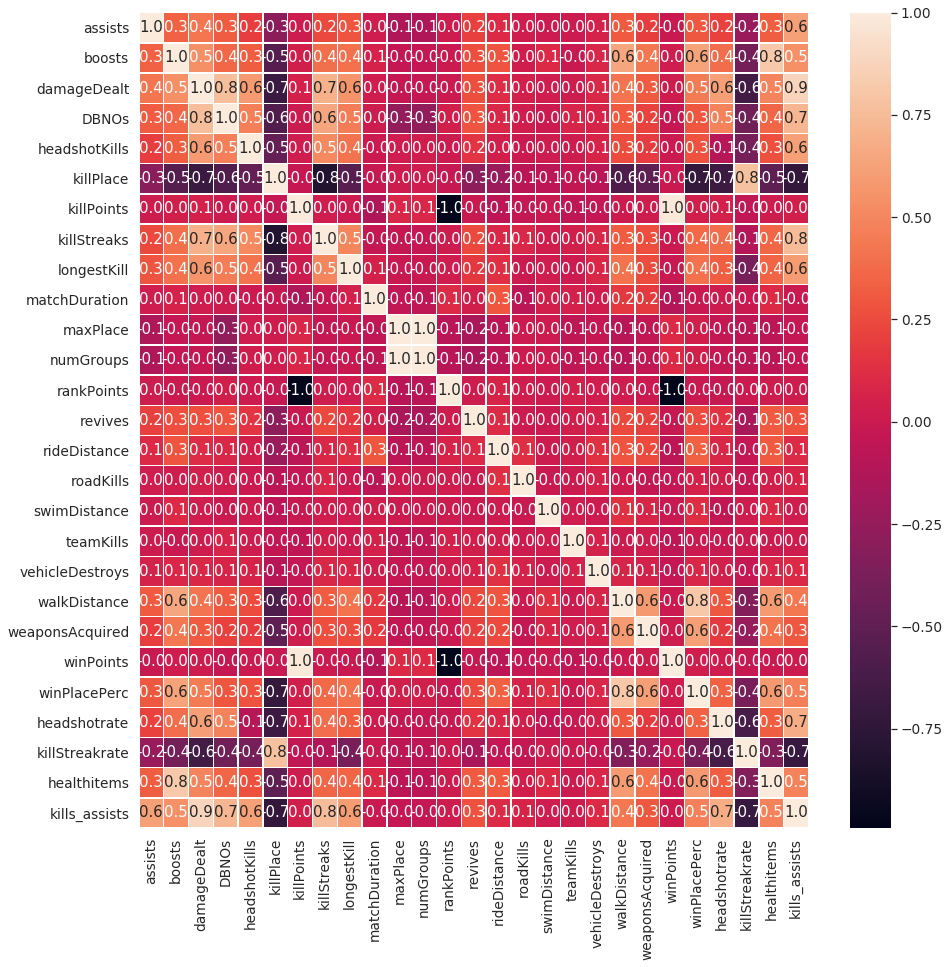

In [0]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

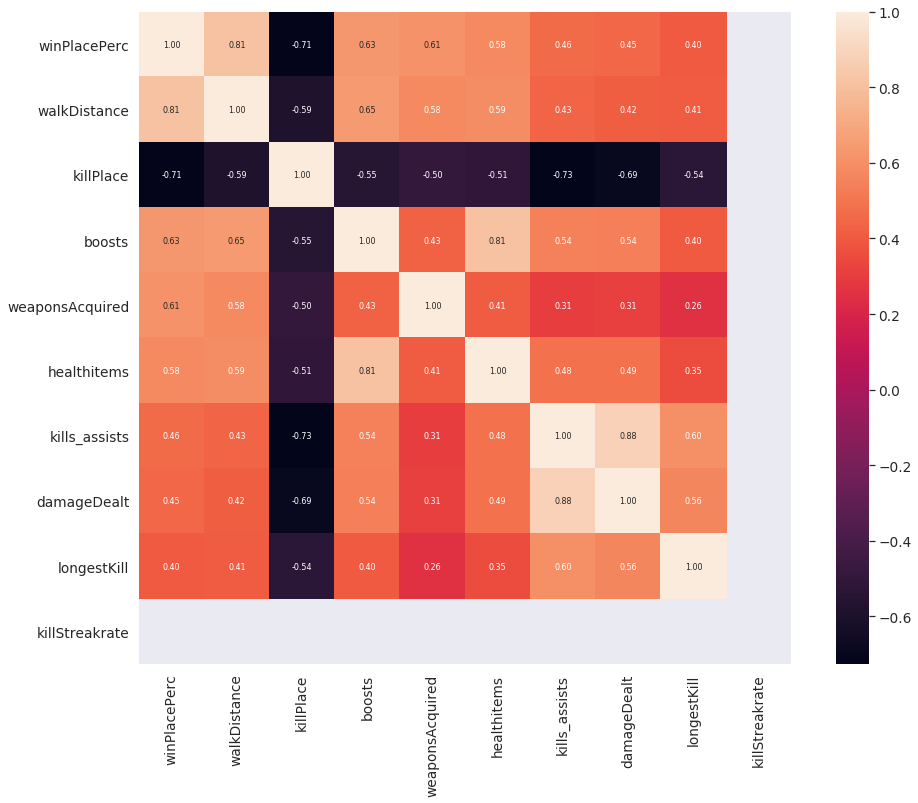

In [0]:
# ヒートマップを表示してみる
k = 10 # 表示する特徴量の数
corrmat = train.corr()
cols = corrmat.abs().nlargest(k, 'winPlacePerc').index # リストの最大値から順にk個の要素の添字(index)を取得
# df_train[cols].head()
cm = np.corrcoef(train[cols].values.T) # 相関関数行列を求める ※転置が必要
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

##データの水増し

In [0]:
def feature_engineering(df, is_train=True): #引数にtrain＝Trueを入れて別の手順を得る
    if is_train: 
        print("processing train.csv")

        df = train         

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = test
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    
    features.remove("matchType")
    
    y = None
    
    
    if is_train: #trainの時は正解データを用意して説明変数のカラムから目的変数のカラムを引く
        print("get target")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']] #参加チーム数に絞る,3000くらい
    else: df_out = df[['matchId','groupId']] #テストデータの数に絞る,1700くらい

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    #gc.collect()

    return X, y

In [8]:
X, y = feature_engineering(train, is_train=True)

processing train.csv
remove some columns
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [9]:
X_test, _ = feature_engineering(train, is_train=False)

processing test.csv
remove some columns
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [0]:
X

Output hidden; open in https://colab.research.google.com to view.

##データ水増し後のヒートマップ

In [0]:
X['winPlacePerc'] = y
train = X

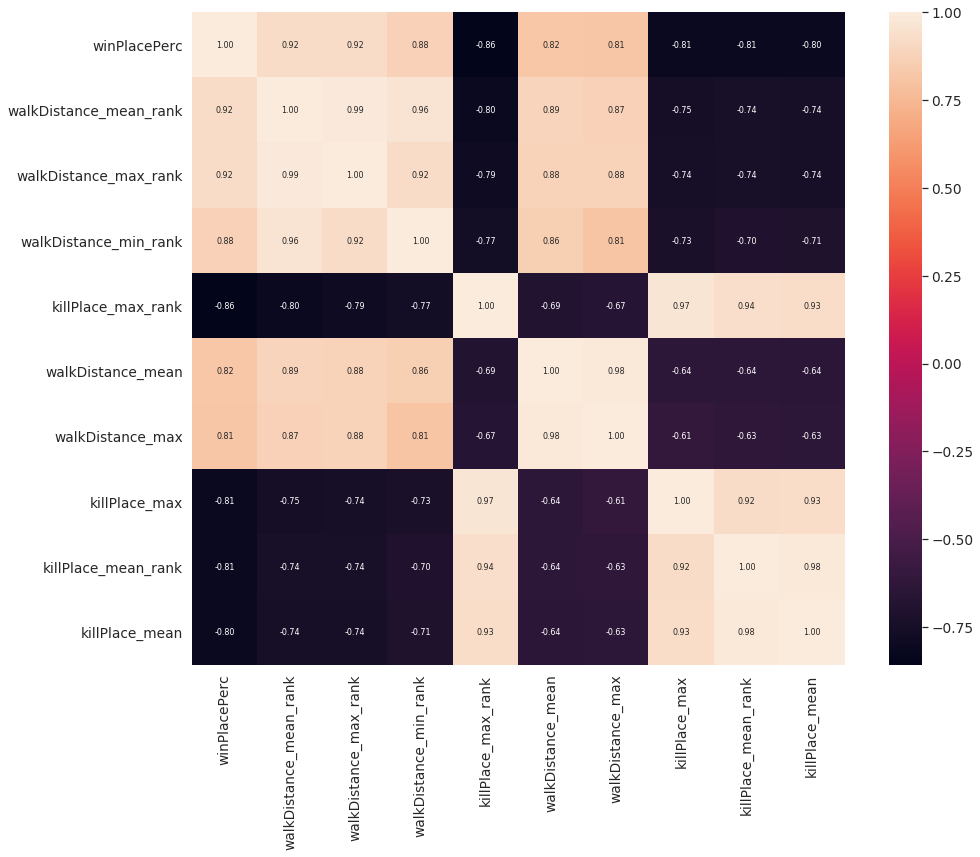

In [0]:
# ヒートマップを表示してみる
k = 10 # 表示する特徴量の数
corrmat = train.corr()
cols = corrmat.abs().nlargest(k, 'winPlacePerc').index # リストの最大値から順にk個の要素の添字(index)を取得
# df_train[cols].head()
cm = np.corrcoef(train[cols].values.T) # 相関関数行列を求める ※転置が必要
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#4.目的変数と説明変数の作成

In [0]:
train

In [0]:
target = 'winPlacePerc'
features = list(train.columns)
features.remove("Id")
features.remove("matchId")
features.remove("groupId")
features.remove("matchType")
features.remove("winPlacePerc")

##4-1.教師データの作成

In [0]:
y = train[target]
#features.remove(target)

##4-2.訓練データの作成

In [0]:
X = train[features]

##4-3.テストデータの作成

In [0]:
X_test = test[features]

#5.学習

In [0]:
# LightGBM
#for i in range(2,8):
    folds = KFold(n_splits=3,random_state=6)
    val_preds = np.zeros(X.shape[0])
    sub_preds = np.zeros(test.shape[0])

    valid_score = 0

    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        trn_x, trn_y = X.iloc[trn_idx], y[trn_idx]
        val_x, val_y = X.iloc[val_idx], y[val_idx]    
        
        train_data = lgb.Dataset(data=trn_x, label=trn_y)
        valid_data = lgb.Dataset(data=val_x, label=val_y)   
        
        params = {"objective" : "regression", "metric" : "mae", 'n_estimators':15000, 'early_stopping_rounds':100,
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.9,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7
                }
        
        lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
        
        val_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
        val_preds[val_preds>1] = 1
        val_preds[val_preds<0] = 0
        sub_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
        sub_pred[sub_pred>1] = 1 # should be greater or equal to 1
        sub_pred[sub_pred<0] = 0 
        print(n_fold+1, '/', folds.n_splits, sub_pred)
        sub_preds += sub_pred/ folds.n_splits
        print('Fold %2d RMAE : %.6f' % (n_fold + 1, mean_absolute_error(val_y, val_preds[val_idx])))
        valid_score += mean_absolute_error(val_y, val_preds[val_idx])/folds.n_splits
    print('valid_score: {}'.format(valid_score))

Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.0145015	valid_1's l1: 0.0481478
[2000]	training's l1: 0.00688771	valid_1's l1: 0.0474939
Early stopping, best iteration is:
[2191]	training's l1: 0.00604435	valid_1's l1: 0.0474359
1 / 3 [0.13078796 0.2425247  0.25036711 ... 0.92675213 0.29325611 0.87047042]
Fold  1 RMAE : 0.047264
Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.0143586	valid_1's l1: 0.0473201
Early stopping, best iteration is:
[1492]	training's l1: 0.00966596	valid_1's l1: 0.0469946
2 / 3 [0.1338492  0.24473947 0.22835999 ... 0.86800308 0.31787038 0.91928249]
Fold  2 RMAE : 0.046808
Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.0144088	valid_1's l1: 0.0483687
[2000]	training's l1: 0.00692934	valid_1's l1: 0.0477992
Early stopping, best iteration is:
[1920]	training's l1: 0.00726139	valid_1's l1: 0.0477761
3 / 3 [0.08615356 0.23330226 0.23998173 ... 0.879

#6.提出

In [0]:
pred = sub_preds
print("fix winPlacePerc")
for i in range(len(X_test)):
    winPlacePerc = pred[i]
    maxPlace = int(X_test.iloc[i]['maxPlace'])
    if maxPlace == 0:
        winPlacePerc = 0.0
    elif maxPlace == 1:
        winPlacePerc = 1.0
    else:
        gap = 1.0 / (maxPlace - 1)
        winPlacePerc = round(winPlacePerc / gap) * gap
    
    if winPlacePerc < 0: winPlacePerc = 0.0
    if winPlacePerc > 1: winPlacePerc = 1.0    
    pred[i] = winPlacePerc

    if (i + 1) % 100000 == 0:
        print(i, flush=True, end=" ")

X_test['winPlacePerc'] = pred

submission = X_test[['winPlacePerc']] #DataFrameをDataFrameのまま抽出する
submission.to_csv(path + 'results/lgbm+n(47).csv', index=False)
submission

fix winPlacePerc


,winPlacePerc
0,0.107143
1,0.250000
2,0.250000
3,0.346939
4,0.510204
...,...
1789,0.600000
1790,0.400000
1791,0.895833
1792,0.280000


#7.方針
EDA=>可視化=>モデル=>ハイパーパラメータ=>学習=>評価

1.データの種類と数を見る<br>
2.目的変数を確認する<br>
3.数値データの相関行列を確認する<br>
4.カテゴリーデータを確認する<br>
連続値なら散布図、離散値なら棒グラフ、相関行列ならヒートマップ<br>
5.説明変数を確認する<br>
5-1.目的変数と相関の強い物を確認する<br>
5-2.説明変数同士で相関の高い物を確認する<br>
6.新たな特徴量を考える=>深層学習(どのようなモデルが良いか?)<br>
エンコーディング、交差項、ドメイン知識

##1からやってみる
1.データをいじらないでLGBM=>0.06<br>2.特徴量を増やしてlgbm=53=><br>3.データ数を水増ししてlgbm=42=>33<br>4.データ数を水増ししてlgbmp=>59<br>5.ハイパーパラメータを入れる=47<br>6.疑問を解消する(目的変数と相関が強いものを選びながら多重共線性を避ける)<br>7.多重共線性を避ける＝主成分分析<br>8.kaggleから探してくる<br>8-1.predをasjustする=>37<br>8-2.keras<br>8-3.simpleNN<br>8-4.Keras+lightGBM+特徴量+水増し